In [1]:
# comparisons by location and by pre and post data
import data_read
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

# File paths
vivosight_folder = "data/Vivosight_data/"
scan_folder = "data/scan_information/"

# Step 1: Initialize collection
subject_ids = data_read.get_all_subject_ids(vivosight_folder)
data = {
    "Subject": [],
    "Scan ID": [],
    "Location ID": [],
    "Exposure": [],
    "Max Vessel Diameter": [],
}

# Step 2: Use process_subject_vivosight_data to get structured info
for subject_id in subject_ids:
    subject = data_read.process_subject_vivosight_data(
        subject_id, vivosight_folder, scan_folder, "bloodflow"
    )

    for visit in [subject.visit, subject.return_visit]:
        if visit and visit.blood_flow:
            # Recalculate min_location_id

            for blood_data in visit.blood_flow:
                blood_data.get_max_diameter()
                # print("check",blood_data.location)

                data["Subject"].append(subject_id)
                data["Scan ID"].append(blood_data.scan_id)
                data["Location ID"].append(blood_data.location)
                data["Exposure"].append("Post" if blood_data.exposed else "Pre")
                data["Max Vessel Diameter"].append(blood_data.max_diameter)

# Create DataFrame
df = pd.DataFrame(data)

# Remove outliers (IQR method)
Q1 = df["Max Vessel Diameter"].quantile(0.25)
Q3 = df["Max Vessel Diameter"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[
    (df["Max Vessel Diameter"] >= lower_bound) &
    (df["Max Vessel Diameter"] <= upper_bound)
]

# Step 5: Run Mann-Whitney U test for Pre vs Post per location
print("Mann-Whitney U Test: Pre vs Post by Location\n")

for loc in [1, 2, 3, 4]:
    pre = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Pre")]["Max Vessel Diameter"]
    post = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Post")]["Max Vessel Diameter"]

    print(f" Location {loc}:")
    print(f"   Pre (n={len(pre)}), Post (n={len(post)})")

    if len(pre) >= 3 and len(post) >= 3:
        stat, p = mannwhitneyu(pre, post, alternative='two-sided')
        sig = " Significant" if p < 0.05 else "Not significant"
        print(f"   Mann-Whitney U p-value = {p:.4f} → {sig}\n")
    else:
        print("    Not enough data to compare\n")

data/Vivosight_data/A52_Results [<data_types.BloodFlow object at 0x11cd532c0>, <data_types.BloodFlow object at 0x11cf525a0>, <data_types.BloodFlow object at 0x11c1b85f0>, <data_types.BloodFlow object at 0x11cf897c0>, <data_types.BloodFlow object at 0x11d08bc20>, <data_types.BloodFlow object at 0x11d08a9f0>, <data_types.BloodFlow object at 0x11d08a600>, <data_types.BloodFlow object at 0x11d08afc0>, <data_types.BloodFlow object at 0x11d08aae0>, <data_types.BloodFlow object at 0x11d08ac90>, <data_types.BloodFlow object at 0x11c975a30>, <data_types.BloodFlow object at 0x11c975790>, <data_types.BloodFlow object at 0x11d06bda0>, <data_types.BloodFlow object at 0x11cf893d0>, <data_types.BloodFlow object at 0x11d06bb30>, <data_types.BloodFlow object at 0x11d06bc20>, <data_types.BloodFlow object at 0x11d06aea0>, <data_types.BloodFlow object at 0x11d06a9f0>, <data_types.BloodFlow object at 0x11d06a540>, <data_types.BloodFlow object at 0x11d06a090>, <data_types.BloodFlow object at 0x11d069bb0>, <

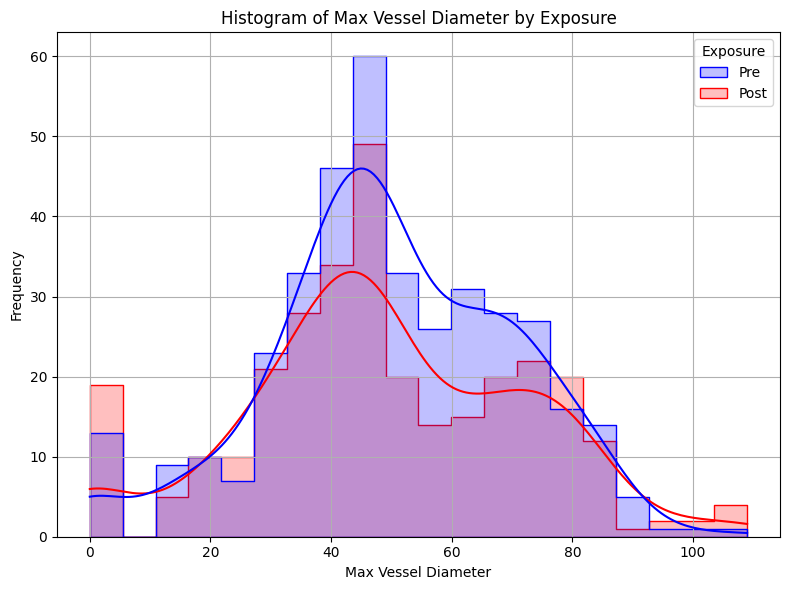

In [3]:
import data_read
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines

# Separated histograms by Exposure
plt.figure(figsize=(8, 6))
sns.histplot(data=df_clean, x="Max Vessel Diameter", hue="Exposure", bins=20, kde=True,
             palette={"Pre": "blue", "Post": "red"}, element="step", stat="count", common_norm=False)
plt.title("Histogram of Max Vessel Diameter by Exposure")
plt.xlabel("Max Vessel Diameter")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

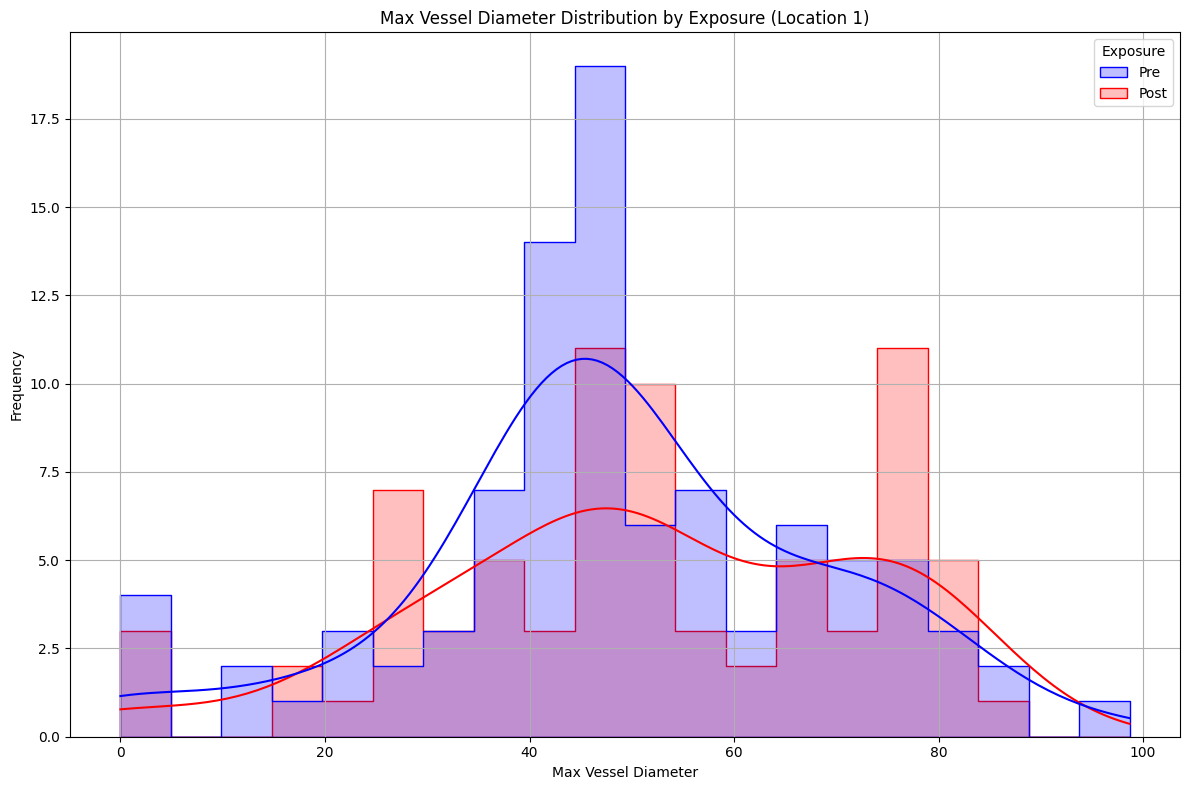

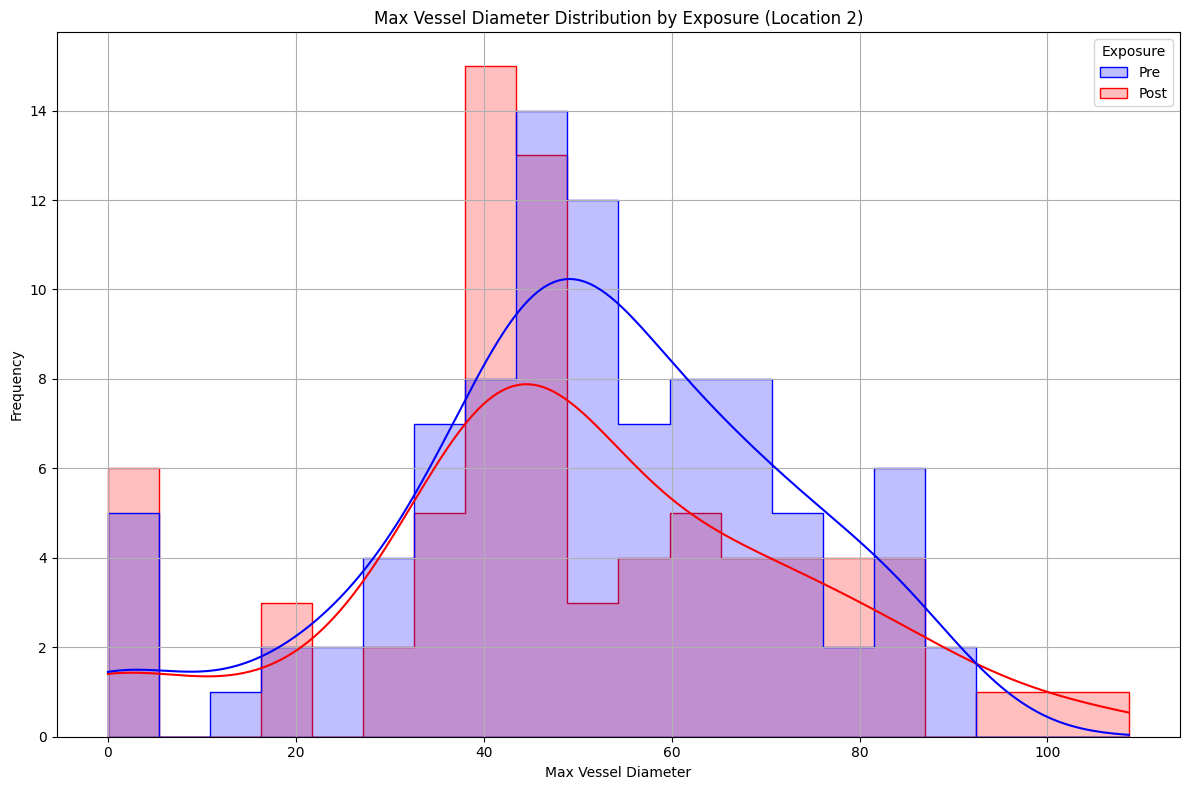

In [5]:
import data_read
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter the data for Locations 1 and 2
df_location_1 = df_clean[df_clean["Location ID"] == 1]
df_location_2 = df_clean[df_clean["Location ID"] == 2]

# Create histogram for Location 1 (Pre and Post exposure)
plt.figure(figsize=(12, 8))
sns.histplot(data=df_location_1, x="Max Vessel Diameter", hue="Exposure", bins=20, kde=True,
             palette={"Pre": "blue", "Post": "red"}, element="step", stat="count", common_norm=False)
plt.title("Max Vessel Diameter Distribution by Exposure (Location 1)")
plt.xlabel("Max Vessel Diameter")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Create histogram for Location 2 (Pre and Post exposure)
plt.figure(figsize=(12, 8))
sns.histplot(data=df_location_2, x="Max Vessel Diameter", hue="Exposure", bins=20, kde=True,
             palette={"Pre": "blue", "Post": "red"}, element="step", stat="count", common_norm=False)
plt.title("Max Vessel Diameter Distribution by Exposure (Location 2)")
plt.xlabel("Max Vessel Diameter")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Calculate mean, median, and standard deviation for Location 1
location_1_stats = df_clean[df_clean["Location ID"] == 1]["Max Vessel Diameter"].agg(['mean', 'median', 'std'])

# Calculate mean, median, and standard deviation for Location 2
location_2_stats = df_clean[df_clean["Location ID"] == 2]["Max Vessel Diameter"].agg(['mean', 'median', 'std'])

# Print the results
print("Location 1 Stats:")
print(location_1_stats)
print("\nLocation 2 Stats:")
print(location_2_stats)

Location 1 Stats:
mean      50.024972
median    48.555414
std       20.456141
Name: Max Vessel Diameter, dtype: float64

Location 2 Stats:
mean      50.225330
median    48.217665
std       22.124114
Name: Max Vessel Diameter, dtype: float64


In [7]:
from scipy.stats import mannwhitneyu

# Get data for Location 1 and Location 2
location_1_data = df_clean[df_clean["Location ID"] == 1]["Max Vessel Diameter"]
location_2_data = df_clean[df_clean["Location ID"] == 2]["Max Vessel Diameter"]

# Perform Mann-Whitney U test (non-parametric test)
stat, p_value = mannwhitneyu(location_1_data, location_2_data, alternative='two-sided')

# Print result
print(f"Mann-Whitney U test p-value: {p_value:.4f}")

# Interpret the result
if p_value < 0.05:
    print("There is a significant difference between the two locations.")
else:
    print("There is no significant difference between the two locations.")

Mann-Whitney U test p-value: 0.8910
There is no significant difference between the two locations.


In [8]:
from scipy.stats import mannwhitneyu

# Get data for Location 3 and Location 4
location_3_data = df_clean[df_clean["Location ID"] == 3]["Max Vessel Diameter"]
location_4_data = df_clean[df_clean["Location ID"] == 4]["Max Vessel Diameter"]

# Perform Mann-Whitney U test (non-parametric test)
stat, p_value = mannwhitneyu(location_3_data, location_4_data, alternative='two-sided')

# Print result
print(f"Mann-Whitney U test p-value for Locations 3 vs 4: {p_value:.4f}")

# Interpret the result
if p_value < 0.05:
    print("There is a significant difference between Locations 3 and 4.")
else:
    print("There is no significant difference between Locations 3 and 4.")


Mann-Whitney U test p-value for Locations 3 vs 4: 0.0657
There is no significant difference between Locations 3 and 4.
